In [ ]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [2]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [3]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [4]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [5]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+1.g958b87542.dirty.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.99 GB available memory.


In [ ]:
eq = get("precise_QA")
eq.axis = eq.surface.get_axis()
eq.set_initial_guess()
opt = Optimizer("sgd")
eq.solve(verbose=3, optimizer=opt, maxiter=1000, options={"alpha": 2e-7, "beta": 0.9});

In [56]:
eq = get("precise_QA")
alpha = 1.2
min_value = 1

def get_mode_scales(modes, scale_type="Linf", ess=False):
    if ess:
        if scale_type == "L1":
            mode_level = np.sum(modes, axis=1)  # |m| + |n|
        elif scale_type == "L2":
            mode_level = np.sqrt(np.sum(modes**2, axis=1))  # sqrt(m² + n²)
        elif scale_type == "Linf":
            mode_level = np.max(modes, axis=1)  # max(|m|,|n|)
        return np.maximum(np.exp(-alpha * mode_level) / np.exp(-alpha), min_value)
    else:
        if modes.shape[1] == 2:
            coef = np.array([1, 1])
        else:
            coef = np.array([1, 1, 1])
        return 1/np.sqrt(np.sum((modes*coef)**2, axis=1) + 1)**2

x_scale = np.ones(eq.dim_x)
x_scale[eq.x_idx["R_lmn"]] = get_mode_scales(eq.R_basis.modes)
x_scale[eq.x_idx["Z_lmn"]] = get_mode_scales(eq.Z_basis.modes)
x_scale[eq.x_idx["L_lmn"]] = get_mode_scales(eq.L_basis.modes)
# x_scale[eq.x_idx["Rb_lmn"]] = get_mode_scales(eq.surface.R_basis.modes[:, 1:])
# x_scale[eq.x_idx["Zb_lmn"]] = get_mode_scales(eq.surface.Z_basis.modes[:, 1:])

In [57]:
x = eq.pack_params(eq.params_dict)
# plt.plot(x)

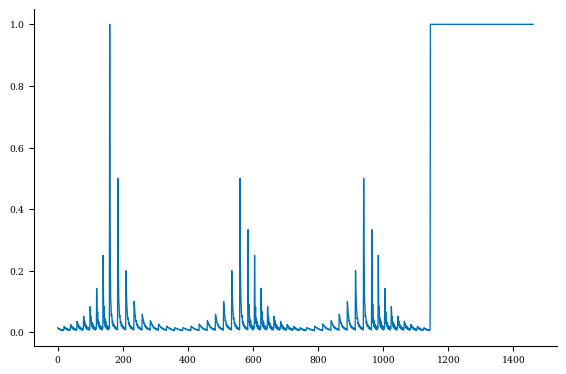

In [58]:
plt.plot(x_scale)

In [65]:
eq2 = get("precise_QA")
eq2.axis = eq2.surface.get_axis()
eq2.set_initial_guess()
opt = Optimizer("adam")
eq2.solve(verbose=3, optimizer=opt, maxiter=100, x_scale=x_scale, xtol=0, options={"alpha": 1e-3});

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 65.0 ms
Timer: Objective build = 74.4 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 147 ms
Timer: LinearConstraintProjection build = 355 ms
Number of parameters: 856
Number of objectives: 5346
Timer: Initializing the optimization = 612 ms

Starting optimization
Using method: adam
Solver options:
----------------------------------------
Alpha          : 1.000e-03
Beta1          : 9.000e-01
Beta2          : 9.990e-01
Epsilon        : 1.000e-08
---------------------------------------- 

   Iteration     Total nfev        Cost      Cost redu

In [55]:
eq2 = get("precise_QA")
eq2.axis = eq2.surface.get_axis()
eq2.set_initial_guess()
opt = Optimizer("scipy-bfgs")
eq2.solve(verbose=3, optimizer=opt, maxiter=100);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 64.3 ms
Timer: Objective build = 74.7 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 150 ms
Timer: LinearConstraintProjection build = 362 ms
Number of parameters: 856
Number of objectives: 5346
Timer: Initializing the optimization = 635 ms

Starting optimization
Using method: scipy-bfgs
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          3.882e+00                                    1.350e+03   
       1              2          3.567e+00      3.151e-01      2.166e-01  

In [ ]:
eq1 = get("precise_QA")
eq1.axis = eq1.surface.get_axis()
eq1.set_initial_guess()
eq1.solve(maxiter=100, verbose=3);

In [ ]:
plot_comparison([eq, eq1, eq2], labels=["sgd", "tr", "adam"]);

In [ ]:
plot_section(eq, "|F|_normalized", log=True);

In [ ]:
plot_section(eq1, "|F|_normalized", log=True);

In [ ]:
plot_section(eq2, "|F|_normalized", log=True);